In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arsenal.profiling
from collections import deque
from arsenal import timers

from transduction.lazy import Lazy
from transduction.fsa import FSA, EPSILON
from transduction import (
    FST, EPSILON, PrecoverDecomp, examples, Precover,    
)
from time import time
from collections import Counter
from transduction.util import display_table
from transduction.goo import LazyPrecoverNFA, LazyPrecoverNFA_slower, NonrecursiveDFADecomp, Token, bpe_wfst

In [3]:
from genlm.backend.tokenization.bytes import get_byte_vocab
from transformers import AutoTokenizer

In [4]:
from transduction import examples
fst = examples.samuel_example()
target = 'c'
decomp = NonrecursiveDFADecomp(fst, target)

In [5]:
decomp.quotient.min()

In [6]:
decomp.remainder.min()

{
}

In [7]:
precover = Precover(fst, target)
precover.show_decomposition()

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 2 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a",∅


In [8]:
assert precover.min.equal(decomp.dfa.materialize())

In [9]:
tok = AutoTokenizer.from_pretrained("gpt2")
decode = get_byte_vocab(tok)
special = {x.encode() for x in tok.special_tokens_map.values()}
fst = bpe_wfst(tok).renumber()

In [10]:
target = (b't', b'h', b'e')

Encodings (not precover, which is significantly larger)

In [11]:
#the = fst.renumber(None, FST.from_string(target).renumber).trim().epsremove().trim().min()
#the

In [12]:
#list(the.language())

In [13]:
len(fst.states)

98024

In [14]:
# def mapping_fst_1(mapping, readable=True):
#     m = FST()
#     m.add_start(())
#     for i, x in mapping.items():
#         _x = x
#         x = tuple(x)
#         for j in range(len(x)):
#             m.add_arc(x[:j], EPSILON, bytes([x[j]]), x[:j+1])
#         if readable:
#             m.add_arc(x, Token(i, _x), EPSILON, ())
#         else:
#             m.add_arc(x, i, EPSILON, ())
#     m.add_stop(())
#     return m

In [15]:
# def mapping_fst(mapping, readable=True):
#     start_state = 0
#     m = FST(start=(start_state,), stop=(start_state,))
#     for token, bytes_vals in mapping.items():        
#         current_state = start_state
#         current_input = Token(token, bytes_vals) if readable else token
#         for idx, byte_val in enumerate(bytes_vals):
#             if idx == len(bytes_vals) - 1:
#                 next_state = start_state
#             else:
#                 next_state = len(m.states)
#             m.add_arc(
#                 current_state,
#                 current_input if idx == 0 else EPSILON,
#                 bytes([byte_val]),
#                 next_state
#             )
#             current_state = next_state
#             current_input = EPSILON
#     return m

In [16]:
# decode = [
#     b'hello',
#     b'hell',
#     b'he',
#     b'h',
#     b'e',
#     b'l',
#     b'll',
#     b'o',
# ]
# fst = mapping_fst(dict(enumerate(decode))).renumber
# target = tuple(bytes([x]) for x in 'hel'.encode())
# special = set()

In [17]:
from tokenization.util import prefixes
decode_prefix_closure = {y for x in set(decode) - special for y in prefixes(x)}   # Note: we drop special tokens here
assert len(decode_prefix_closure) == len(fst.states)

In [18]:
#target = tuple(bytes([x]) for x in b'Timothy')

In [19]:
#from arsenal import timeit
#with timeit(''):
#    P = LazyPrecoverNFA(fst, target).materialize()

In [21]:
# from tokenization.character_beam_trie import CharacterBeam, flatten
# C = CharacterBeam(lm.lm, K=100)
# Q = set()
# Q2 = set()
# for x in C.unbundle(b''.join(target)):
#     #print(x)
#     Q.add(tuple(lm.lm._encode[y] for y in flatten(x.ys)))
#     Q2.add(tuple(y for y in flatten(x.ys)))

In [22]:
# i = 0
# for x in P.language():
#     print(x)
#     i += 1
#     if i > 15: break

In [23]:
T = timers()
for _ in range(3):    
    with T['fast']:
        fast = LazyPrecoverNFA(fst, target).materialize()#.renumber().trim().epsremove().trim()
    with T['slow']:
        slow = LazyPrecoverNFA_slower(fst, target).materialize()#.renumber().trim().epsremove().trim()

T.compare()

slow is 1.6822x faster than fast (p=1.00000, median: fast: 0.964389, slow: 0.573277)


In [24]:
len(fast.states), len(slow.states)

(98030, 98030)

wrote: /tmp/out.prof (use `gprof-viz` to view)


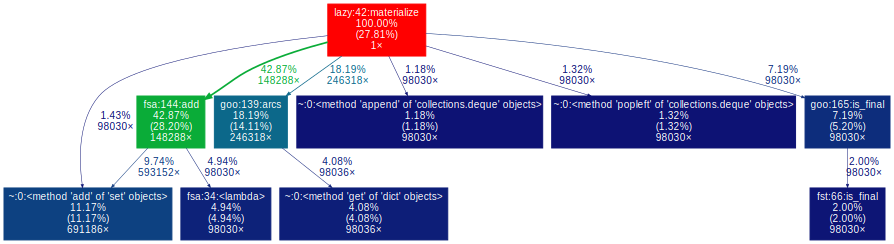

In [25]:
p = arsenal.profiling.profiler()
with p:
    precover = LazyPrecoverNFA(fst, target).materialize()
p.graphviz()

In [26]:
precover = precover.renumber()

In [27]:
len(precover.states)

98030

In [28]:
# p = arsenal.profiling.profiler()
# with p:
#     self = precover.lazy().epsremove()#.materialize()

#     #m = FSA()
#     worklist = deque()
#     visited = set()
#     dups = Counter()
#     popped = set()

#     last_update = time()
#     for i in self.start():
#         worklist.append(i)
#         visited.add(i)
#         #m.add_start(i)
#     while worklist:
#         i = worklist.popleft()
#         assert i not in popped
#         popped.add(i)
#         if self.is_final(i):
#             #m.add_stop(i)
#             pass
#         for a, j in self.arcs(i):
#             if j not in visited:
#                 visited.add(j)
#                 worklist.append(j)
#                 dups[j] += 1
#             #m.add(i,a,j)
#         now = time()
#         if now - last_update > 1:
#             print(len(visited), len(popped))
#             last_update = now
#         if len(popped) == len(precover.states):   # visited every state... why are we still spinning?
#             break

In [ ]:
p = arsenal.profiling.profiler()
with p:
    decomp = NonrecursiveDFADecomp(fst, target)

In [ ]:
p.graphviz()

In [ ]:
#p.graphviz()

In [ ]:
#decomp.source_alphabet

In [ ]:
decomp.quotient

In [ ]:
decomp.fsa.det().materialize()

In [ ]:
decomp.quotient.renumber().trim()

In [ ]:
decomp.remainder.renumber().trim()

In [ ]:
from transduction.enumeration import prioritized_enumeration
from tokenization.statelm import StateLM
lm = StateLM.initial('gpt2')

In [ ]:
pe = prioritized_enumeration(lm, fst, target, max_steps=20)

In [ ]:
len(pe.remainder_terms)

In [ ]:
len(pe.quotient_terms)

In [ ]:
pe.quotient_terms[0].source

In [ ]:
from transduction.enumeration import crude_importance_sampling, importance_sampling, Item, logsumexp, sample

In [ ]:
sampler = importance_sampling(lm, fst, target)

In [ ]:
item = sampler.sample()
item.weight, item.source

In [ ]:
crude = crude_importance_sampling(lm, fst, target)

In [ ]:
item = crude.sample()
item